# Forest Cover Classification

### **By Vinesh Raghvani**

In this project, I will be using deep learning to forecast forest cover type (the most prevalent form of tree cover) using just cartographic data. The actual forest cover type for a specific 30 × 30 meter cell was identified using US Forest Service (USFS) Region 2 Resource Information System data. The cover types are as follows:

1. Spruce/Fir
1. Lodgepole Pine
1. Ponderosa Pine
1. Cottonwood/Willow
1. Aspen
1. Douglas-fir
1. Krummholz

## Importing Libraries

In [54]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [55]:
tf.get_logger().setLevel('ERROR')

# Going to turn off the GPU usage for tensorflow
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Defining a function to sort and prepare the data for usage 

In [56]:
def prep_data(raw_df):
    """
    Going to process the data for ML/DL algorithms.
    - Separate features and target variables
    - Divide into training and testing dataset
    - Normalize numerical data

    Parameters: 'raw_df' - It is a CSV file that contains the data needed
    Output: X_train, X_test, Y_train, Y_test
    """

    data = raw_df.values
    X, Y = data[:, :-1], data[:, -1]

    # Dividing into training and testing set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

    # Normalize Data
    normalizer = StandardScaler()
    X_train = normalizer.fit_transform(X_train)
    X_test = normalizer.fit_transform(X_test)

    return X_test, X_train, Y_train, Y_test

## Defining a Build Model function 

In [57]:
def create_neural_network(input_features):
    """
    Construct and compile a neural network model.

    Parameters: 'input_features' - Number of input features
    Output: Compiled neural network model.
    """
    classifier = keras.Sequential(name='Neural_Network_Classifier')
    classifier.add(layers.Dense(64, input_dim=input_features, activation='relu'))
    #classifier.add(layers.Dropout(rate=0.3, name='Dropout_1'))
    classifier.add(layers.Dense(units=32, activation='relu'))
    #classifier.add(layers.Dropout(rate=0.3, name='Dropout_2'))
    classifier.add(layers.Dense(units=8, activation='softmax'))
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier


## Defining a Confusion Matrix and Heatmap function

In [58]:
def generate_confusion_heatmap(categories, Y_pred, Y_test):
    """
    Generate and save a heatmap visualization of the Confusion Matrix.

    Parameters: categories, Y_pred, Y_test
    Output: a PNG file of the generated heatmap.
    """
    confusion_mat = confusion_matrix(Y_test, Y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    confusion_heatmap = sns.heatmap(confusion_mat, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('Actual Labels')
    ax.set_title('Heatmap of Confusion Matrix')
    ax.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
    ax.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
    # Save the generated heatmap to file
    confusion_heatmapfig = confusion_heatmap.get_figure()
    confusion_heatmapfig.savefig('heatmap_confusion_matrix.png')


## Defining a funtion to check the performance of the Model

In [59]:
def visualize_training_performance(training_history, metric):
    """
    Visualize the performance of the model across epochs for a given metric.
    """
    training_history = training_history.history
    #epochs = range(1, len(metrics['accuracy']) + 1)

    if metric == 'accuracy':
        plt.figure(figsize=(10, 6))
        plt.plot(training_history['accuracy'], 'r', label='Training Accuracy')
        plt.plot(training_history['val_accuracy'], 'b', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
    elif metric == 'loss':
        plt.figure(figsize=(10, 6))
        plt.plot(training_history['loss'], 'r', label='Training Loss')
        plt.plot(training_history['val_loss'], 'b', label='Validation Loss')
        plt.title('Training and Validation Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


## Defining a main() function below which will prepare the dataset, builds the model, evaluates the model and gives predictions. Then we will plot the performance metrics.

In [60]:
def main():
    file = 'cover_data.csv'
    raw_df = pd.read_csv(file)

    cols = raw_df.columns.tolist()
    features, label = cols[:-1], cols[-1]
    X_train, X_test, Y_train, Y_test = prep_data(raw_df)

    # Building the DL/ML Model
    input_features = len(features)
    model = create_neural_network(input_features)

    print('Summary Report of Keras Classifier: ')
    model.summary()

    num_epochs = 100
    batch_size = 1024
    earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)
    training_history = model.fit(X_train,
                                    Y_train,
                                    epochs=num_epochs,
                                    batch_size=batch_size,
                                    callbacks=[earlystop_callback],
                                    validation_split=0.1,
                                    verbose=1)
    
    visualize_training_performance(training_history, 'accuracy')
    visualize_training_performance(training_history, 'loss')

    score = model.evaluate(X_test, Y_test, verbose=0)
    print(f'Test Loss: {score[0]}')
    print(f'Test Accuracy: {score[1]}')

    Y_pred = model.predict(X_test)

    #Converting the prediction values to discrete values
    Y_pred = np.argmax(Y_pred, axis=1)
    categories = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine',
                  'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(Y_test, Y_pred, target_names=categories))
    generate_confusion_heatmap(categories, Y_pred, Y_test)

Summary Report of Keras Classifier: 


c:\Users\dexte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Neural_Network_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,864 (22.91 KB)

 Trainable params: 5,864 (22.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4014 - loss: 1.5875 - val_accuracy: 0.4803 - val_loss: 1.2251
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4824 - loss: 1.2253 - val_accuracy: 0.4852 - val_loss: 1.2089
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4863 - loss: 1.2097 - val_accuracy: 0.4844 - val_loss: 1.2065
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4883 - loss: 1.2088 - val_accuracy: 0.4837 - val_loss: 1.2053
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4894 - loss: 1.2070 - val_accuracy: 0.4858 - val_loss: 1.2033
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4901 - loss: 1.2026 - val_accuracy: 0.4860 - val_loss: 1.2041
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4881 - loss: 1.2033 - val_accuracy: 0.4852 - val_loss: 1.2038
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4909 - loss: 1.2040 - val_accu

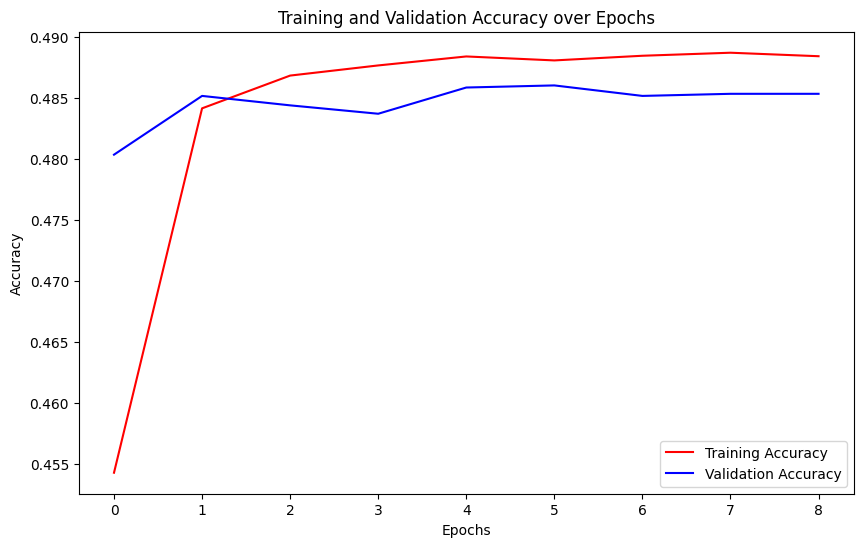

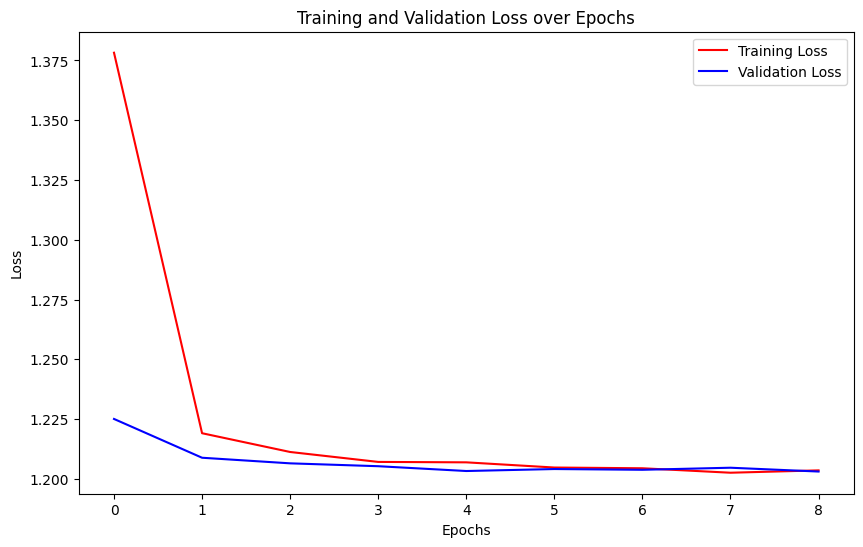

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 464809
'y' sizes: 116203


In [61]:
main()